In [97]:
import csv
import os
import pandas as pd
import requests
import pycountry
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download("words") 
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package words to /Users/lixinyi/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lixinyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lixinyi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lixinyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [215]:
df1=pd.read_csv('df1.csv')

In [216]:
from platform import python_version
print(python_version())

3.9.5


In [217]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
stopwords = set(stopwords.words("english"))

In [ ]:
# ============================================== #
# ============== Feature Study ================= #
# ============================================== #

In [248]:
# make a new column to highlight retweets 
# ===========  in raw data collection, retweets is removed in query
test3=df1
test3['is_retweet'] = test3['text'].apply(lambda x: x[:2]=='RT')
test3['is_retweet'].sum()  # number of retweets, counting from 1 , so it's correct

1

In [251]:
# 10 most repeated tweets
test3.groupby(['text']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(5)

,text,counts
1259,Are you T-Mobile #5G fast? Play this interacti...,6
1386,Are you T-Mobile #5G fast? Play this interacti...,6
1502,Are you T-Mobile #5G fast? Play this interacti...,5
1372,Are you T-Mobile #5G fast? Play this interacti...,5
1337,Are you T-Mobile #5G fast? Play this interacti...,5


<ipython-input-252-7b00dd5c4c9f>:15: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


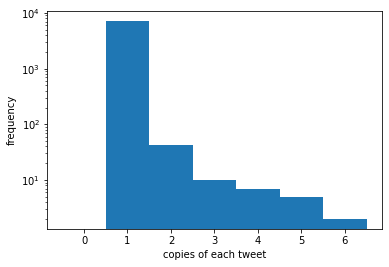

In [252]:
# how the number-of-copies of each tweet are distributed?
# number of times each tweet appears
counts = test3.groupby(['text']).size()\
           .reset_index(name='counts')\
           .counts

# define bins for histogram
my_bins = np.arange(0,counts.max()+2, 1)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('copies of each tweet')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [254]:
def find_retweeted(text):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', text)
# two sample tweets
my_tweet = 'RT @our_codingclub: Can @you find #all the #hashtags?'
my_other_tweet = 'Not a retweet. All views @my own'

In [255]:
def find_mentioned(text):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', text) 
# two sample tweets
my_tweet = 'RT @our_codingclub: Can @you find #all the #hashtags?'
my_other_tweet = 'Not a retweet. All views @my own'

In [256]:
def find_hashtags(text):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', text)   
# two sample tweets
my_tweet = 'RT @our_codingclub: Can @you find #all the #hashtags?'
my_other_tweet = 'Not a retweet. All views @my own'

In [257]:
# make new columns for retweeted usernames, mentioned usernames and hashtags
test3['retweeted'] = test3.text.apply(find_retweeted)
test3['mentioned'] = test3.text.apply(find_mentioned)
test3['hashtags'] = test3.text.apply(find_hashtags)

In [258]:
test3

,created_at,text,id,author_id,geo.name,geo.country_code,geo.country,geo.place_type,geo.geo.bbox,geo.full_name,...,author.public_metrics.listed_count,author.location,lon,lat,lon1,lat2,is_retweet,retweeted,mentioned,hashtags
0,2021-04-29T23:39:55.000Z,Customers are loving this 5G for All Trade in ...,1387914576784592896,992609029326176257,T-Mobile,US,Etats-Unis,poi,"-117.98766875335787, 33.70094049431383, -117.9...",T-Mobile,...,0,NaN,-117.987669,33.700940,-117.987669,33.700940,False,[],"[@JonFreier, @SamSindha, @rwashley1, @JordanaT...",[]
1,2021-04-29T23:33:03.000Z,These 5G speeds are crazy! @TMobile #WeWontSto...,1387912847909220352,66944716,Los Angeles,US,Etats-Unis,city,"-118.668404, 33.704538, -118.155409, 34.337041","Los Angeles, CA",...,2,"Los Angeles, CA",-118.668404,33.704538,-118.155409,34.337041,False,[],[@TMobile],"[#WeWontStop, #iPhone12ProMax]"
2,2021-04-29T23:02:52.000Z,This reads very strangely because it’s an inco...,1387905252066832384,18609072,Lansing,US,Etats-Unis,city,"-84.63184, 42.6185662, -84.483958, 42.805532","Lansing, MI",...,143,No more than 6 miles from a body of water,-84.631840,42.618566,-84.483958,42.805532,False,[],[],[]
3,2021-04-29T23:02:26.000Z,5G any% speedrun but this time no batch number...,1387905142414970880,131124398,Christchurch City,NZ,Nouvelle-Zélande,city,"172.361529, -43.901673, 173.130204, -43.38989","Christchurch City, New Zealand",...,2,"Christchurch, New Zealand",172.361529,-43.901673,173.130204,-43.389890,False,[],[],[]
4,2021-04-29T22:40:15.000Z,I can hear colors with the 5G update https://t...,1387899559033061377,3496928065,University,US,Etats-Unis,city,"-81.2244846, 28.56471, -81.170066, 28.61218","University, FL",...,39,East Central Florida,-81.224485,28.564710,-81.170066,28.612180,False,[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7264,2021-01-26T15:42:40.000Z,Are you T-Mobile #5G fast? Play this interacti...,1354092399551803392,525718531,Austin,US,Etats-Unis,city,"-97.928935, 30.127892, -97.5805133, 30.5187994","Austin, TX",...,91,Austin -won trip to SB SLVII,-97.928935,30.127892,-97.580513,30.518799,False,[],[@useek_official],"[#GalaxyS21, #TMobileTuesdays, #useek]"
7265,2021-01-26T15:42:01.000Z,Are you T-Mobile #5G fast? Play this interacti...,1354092235453771777,698734711326298112,Asheville,US,Etats-Unis,city,"-82.681852, 35.421216, -82.452163, 35.656929","Asheville, NC",...,2,"Asheville, NC",-82.681852,35.421216,-82.452163,35.656929,False,[],[@useek_official],"[#GalaxyS21, #TMobileTuesdays, #useek]"
7266,2021-01-26T15:41:57.000Z,Are you T-Mobile #5G fast? Play this interacti...,1354092218240393217,698734711326298112,Asheville,US,Etats-Unis,city,"-82.681852, 35.421216, -82.452163, 35.656929","Asheville, NC",...,2,"Asheville, NC",-82.681852,35.421216,-82.452163,35.656929,False,[],[@useek_official],"[#GalaxyS21, #TMobileTuesdays, #useek]"
7267,2021-01-26T15:41:50.000Z,Are you T-Mobile #5G fast? Play this interacti...,1354092190520254465,698734711326298112,Asheville,US,Etats-Unis,city,"-82.681852, 35.421216, -82.452163, 35.656929","Asheville, NC",...,2,"Asheville, NC",-82.681852,35.421216,-82.452163,35.656929,False,[],[@useek_official],"[#GalaxyS21, #TMobileTuesdays, #useek]"


In [271]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = test3.loc[test3.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
hashtags_list_df.head(3)

,hashtags
1,"[#WeWontStop, #iPhone12ProMax]"
8,[#Smeargle]
9,"[#uae, #dubai, #sharja, #ajman, #AbuDhabi, #Mi..."


In [272]:
# which hashtags were popular? 
# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
flattened_hashtags_df.head(3)

,hashtag
0,#WeWontStop
1,#iPhone12ProMax
2,#Smeargle


In [273]:
# number of unique hashtags
flattened_hashtags_df['hashtag'].unique().size

4155

In [275]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_hashtags

,hashtag,counts
0,#Verizon5GAccess,566
1,#Sweepstakes,553
2,#Oscars,545
3,#GalaxyS21,468
4,#TMobileTuesdays,450
...,...,...
4150,#S21,1
4151,#S215G,1
4152,#S21EpicMoments,1
4153,#S21ultra,1


<ipython-input-276-38b51c02b1bf>:15: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


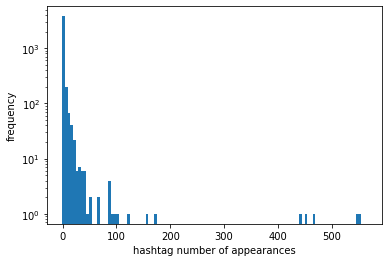

In [276]:
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [277]:
# who were the top people being mentioned ?

In [278]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df.head(3)
mentioned_list_df = test3.loc[test3.mentioned.apply(
                           lambda mentioned_list: mentioned_list !=[]
                       ),['mentioned']]
flattened_mentioned_df = pd.DataFrame(
    [mentioned for mentioned_list in mentioned_list_df.mentioned
    for mentioned in mentioned_list],
    columns=['mentioned'])

In [279]:
flattened_mentioned_df['mentioned'].unique().size

1663

In [281]:
popular_mentioned = flattened_mentioned_df.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_mentioned

,mentioned,counts
0,@useek_official,442
1,@TMobile,213
2,@Verizon,83
3,@MargaretSiegien,83
4,@Fabriziobustama,80
...,...,...
1658,@OnePlus_FI,1
1659,@OnePlus,1
1660,@Omnispace,1
1661,@OmarChughtai,1


In [ ]:
# ------ hashtag correlation ------- #

In [300]:
# take hashtags which appear at least this amount of times
min_appearance = 50
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

In [301]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

In [302]:
# vectorise hashtags - turn the text into numeric form

In [303]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))
print(hashtag_vector_df)

                            popular_hashtags  #Oscars  #IoT  #innovation  \
48                                   [#tech]        0     0            0   
124                     [#technology, #tech]        0     0            0   
145                        [#Samsung, #tech]        0     0            0   
152                               [#Samsung]        0     0            0   
164                            [#Tech, #IoT]        0     1            0   
...                                      ...      ...   ...          ...   
7263  [#GalaxyS21, #TMobileTuesdays, #useek]        0     0            0   
7264  [#GalaxyS21, #TMobileTuesdays, #useek]        0     0            0   
7265  [#GalaxyS21, #TMobileTuesdays, #useek]        0     0            0   
7266  [#GalaxyS21, #TMobileTuesdays, #useek]        0     0            0   
7267  [#GalaxyS21, #TMobileTuesdays, #useek]        0     0            0   

      #Robotics  #Nomadland  #TrakinTech  #Verizon5GAccess  #AI  #tech  ...  \
48      

In [304]:
# drop the popular_hashtags column
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

In [305]:
import seaborn as sns

In [306]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()
correlations

,#Oscars,#IoT,#innovation,#Robotics,#Nomadland,#TrakinTech,#Verizon5GAccess,#AI,#tech,#MyFamily,#GalaxyS21,#MachineLearning,#TMobileTuesdays,#KeepTrakin,#IIoT,#Samsung,#technology,#useek,#Sweepstakes,#Tech
#Oscars,1.000000,-0.227971,-0.127439,-0.145062,0.346745,-0.175889,0.920035,-0.237469,-0.167115,0.348895,-0.442665,-0.166118,-0.431276,-0.196086,-0.121082,-0.170078,-0.140546,-0.426598,0.892928,-0.173969
#IoT,-0.227971,1.000000,0.406748,0.573966,-0.079048,-0.085247,-0.247028,0.647003,0.056204,-0.079538,-0.214544,0.609138,-0.209024,-0.095036,0.506553,-0.082431,-0.025328,-0.206757,-0.242970,0.560085
#innovation,-0.127439,0.406748,1.000000,0.376315,-0.044189,-0.047654,-0.138093,0.264509,0.168121,-0.044463,-0.119933,0.338092,-0.116847,-0.053127,0.090060,-0.046080,0.015402,-0.115580,-0.135824,0.408903
#Robotics,-0.145062,0.573966,0.376315,1.000000,-0.050299,-0.054244,-0.157188,0.570625,0.124263,-0.050611,-0.136517,0.628532,-0.133005,-0.060473,0.398676,-0.052452,-0.011712,-0.131562,-0.154606,0.507555
#Nomadland,0.346745,-0.079048,-0.044189,-0.050299,1.000000,-0.060989,0.319995,-0.082341,-0.057946,-0.056904,-0.153492,-0.057600,-0.149543,-0.067992,-0.041985,-0.058974,-0.048733,-0.147921,0.325340,-0.060323
#TrakinTech,-0.175889,-0.085247,-0.047654,-0.054244,-0.060989,1.000000,-0.190593,-0.088799,-0.062491,-0.061367,-0.165530,-0.062118,-0.161271,0.788086,-0.045277,-0.063599,-0.039249,-0.159521,-0.187462,-0.065054
#Verizon5GAccess,0.920035,-0.247028,-0.138093,-0.157188,0.319995,-0.190593,1.000000,-0.257320,-0.181084,0.321979,-0.479669,-0.180004,-0.467328,-0.212478,-0.131204,-0.184295,-0.152294,-0.462259,0.972528,-0.188511
#AI,-0.237469,0.647003,0.264509,0.570625,-0.082341,-0.088799,-0.257320,1.000000,0.039602,-0.082852,-0.219012,0.681730,-0.217732,-0.098995,0.414718,-0.077146,-0.039886,-0.215370,-0.253092,0.484760
#tech,-0.167115,0.056204,0.168121,0.124263,-0.057946,-0.062491,-0.181084,0.039602,1.000000,-0.058305,-0.157271,0.096546,-0.153225,-0.069666,0.036936,-0.036988,0.395540,-0.151563,-0.178109,-0.050320
#MyFamily,0.348895,-0.079538,-0.044463,-0.050611,-0.056904,-0.061367,0.321979,-0.082852,-0.058305,1.000000,-0.154444,-0.057958,-0.150470,-0.068414,-0.042245,-0.059339,-0.049036,-0.148838,0.327357,-0.060697


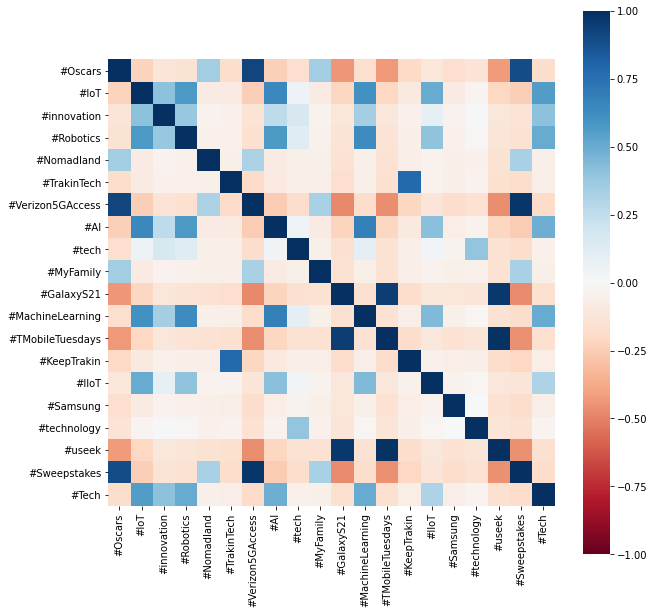

In [307]:
# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True)
plt.show()

# strong correlations : # GalaxyS21 and #Verizon5GAccess
# strong negative correlation :#useek and #TMobileTuesdays

In [ ]:
# ============================================== #
# ============  Exploration Part 2  ============ #
# ============================================== #

In [218]:
# Normalization

In [219]:
test=df1

In [220]:
test1= test[['text']]
test1.head(1)

,text
0,Customers are loving this 5G for All Trade in ...


In [225]:
# cleaning TEXT (RT, Punctuation etc)
#Creating new dataframe and new features
test1["tweet_text"] = test1['text']
test1.head(1)

<ipython-input-225-2b2cac360b7c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1["tweet_text"] = test1['text']


,text,tweet_text
0,Customers are loving this 5G for All Trade in ...,Customers are loving this 5G for All Trade in ...


In [227]:
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
test1["text"] = test1.text.map(remove_rt).map(rt)
test1["text"] = test1.text.str.lower()
test1.head(1)

<ipython-input-227-1d8c22cd428e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1["text"] = test1.text.map(remove_rt).map(rt)
<ipython-input-227-1d8c22cd428e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1["text"] = test1.text.str.lower()


,text,tweet_text
0,customers are loving this 5g for all trade in ...,Customers are loving this 5G for All Trade in ...


In [230]:
# List of all hashtags added to a new column as a new feature ‘hashtag’
test1['hashtag'] = test1['tweet_text'].apply(lambda x: re.findall(r"#(\w+)", x))
test1.head(3)

<ipython-input-230-f9b841cbc409>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['hashtag'] = test1['tweet_text'].apply(lambda x: re.findall(r"#(\w+)", x))


,text,tweet_text,hashtag
0,customers are loving this 5g for all trade in ...,Customers are loving this 5G for All Trade in ...,[]
1,these 5g speeds are crazy wewontstop ipho...,These 5G speeds are crazy! @TMobile #WeWontSto...,"[WeWontStop, iPhone12ProMax]"
2,this reads very strangely because it s an inco...,This reads very strangely because it’s an inco...,[]


In [232]:
#mytest = test1[['text']]
mytest=test1[['text','hashtag']]

In [72]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lixinyi/nltk_data...


True

In [233]:
## Sentiment Analysis
#Calculating Negative, Positive, Neutral and Compound values
mytest[['polarity', 'subjectivity']] = mytest['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in mytest['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        mytest.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        mytest.loc[index, 'sentiment'] = "positive"
    else:
        mytest.loc[index, 'sentiment'] = "neutral"
    mytest.loc[index, 'neg'] = neg
    mytest.loc[index, 'neu'] = neu
    mytest.loc[index, 'pos'] = pos
    mytest.loc[index, 'compound'] = comp
mytest.head(10)

,text,hashtag,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,customers are loving this 5g for all trade in ...,[],0.600000,0.950000,positive,0.000,0.837,0.163,0.5994
1,these 5g speeds are crazy wewontstop ipho...,"[WeWontStop, iPhone12ProMax]",-0.600000,0.900000,negative,0.286,0.714,0.000,-0.3400
2,this reads very strangely because it s an inco...,[],0.149821,0.446964,negative,0.149,0.791,0.059,-0.4754
3,5g any speedrun but this time no batch number...,[],0.000000,0.000000,negative,0.229,0.653,0.118,-0.3291
4,i can hear colors with the 5g update,[],0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
5,i can feel it in the air board game nights may...,[],-0.400000,0.400000,neutral,0.000,1.000,0.000,0.0000
6,i am picking up all sorts of radio signals th...,[],0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
7,bill gates s lowkey 5g,[],0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
8,trying in vain to get the rare shiny smeargle...,[Smeargle],-0.013333,0.446667,negative,0.154,0.779,0.067,-0.5859
9,family processing services center call 0433...,"[uae, dubai, sharja, ajman, AbuDhabi, MiddleEa...",-0.100000,0.100000,neutral,0.000,1.000,0.000,0.0000


In [234]:
#Creating new data frames for all sentiments (positive, negative and neutral)
mytest_negative = mytest[mytest["sentiment"]=="negative"]
mytest_positive = mytest[mytest["sentiment"]=="positive"]
mytest_neutral = mytest[mytest["sentiment"]=="neutral"]

In [235]:
#Function for count_values_in single columns
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(mytest,"sentiment")

,Total,Percentage
positive,4049,55.70
neutral,2164,29.77
negative,1056,14.53


In [236]:
#!pip install pycountry

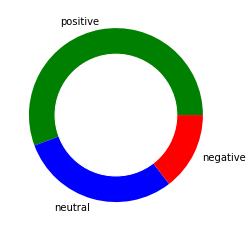

In [115]:
# create data for Pie Chart
pichart = count_values_in_column(mytest,"sentiment")
names= pichart.index

size=pichart["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

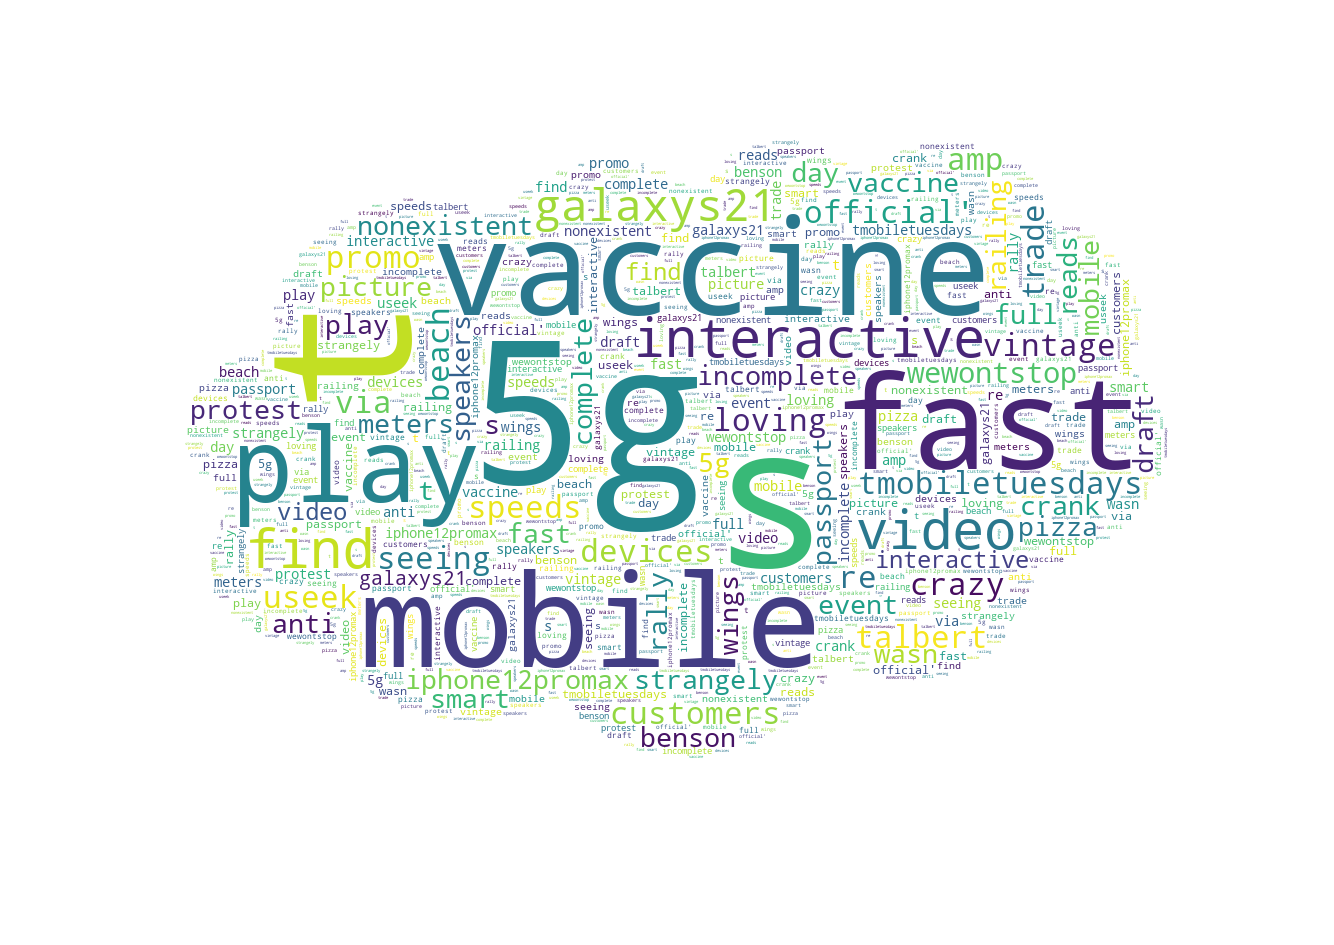

In [198]:
#Function to Create Wordcloud
def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=20000, #by default it's 200
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    path="wc.png"
    display(Image.open(path))
create_wordcloud(mytest["text"].values)

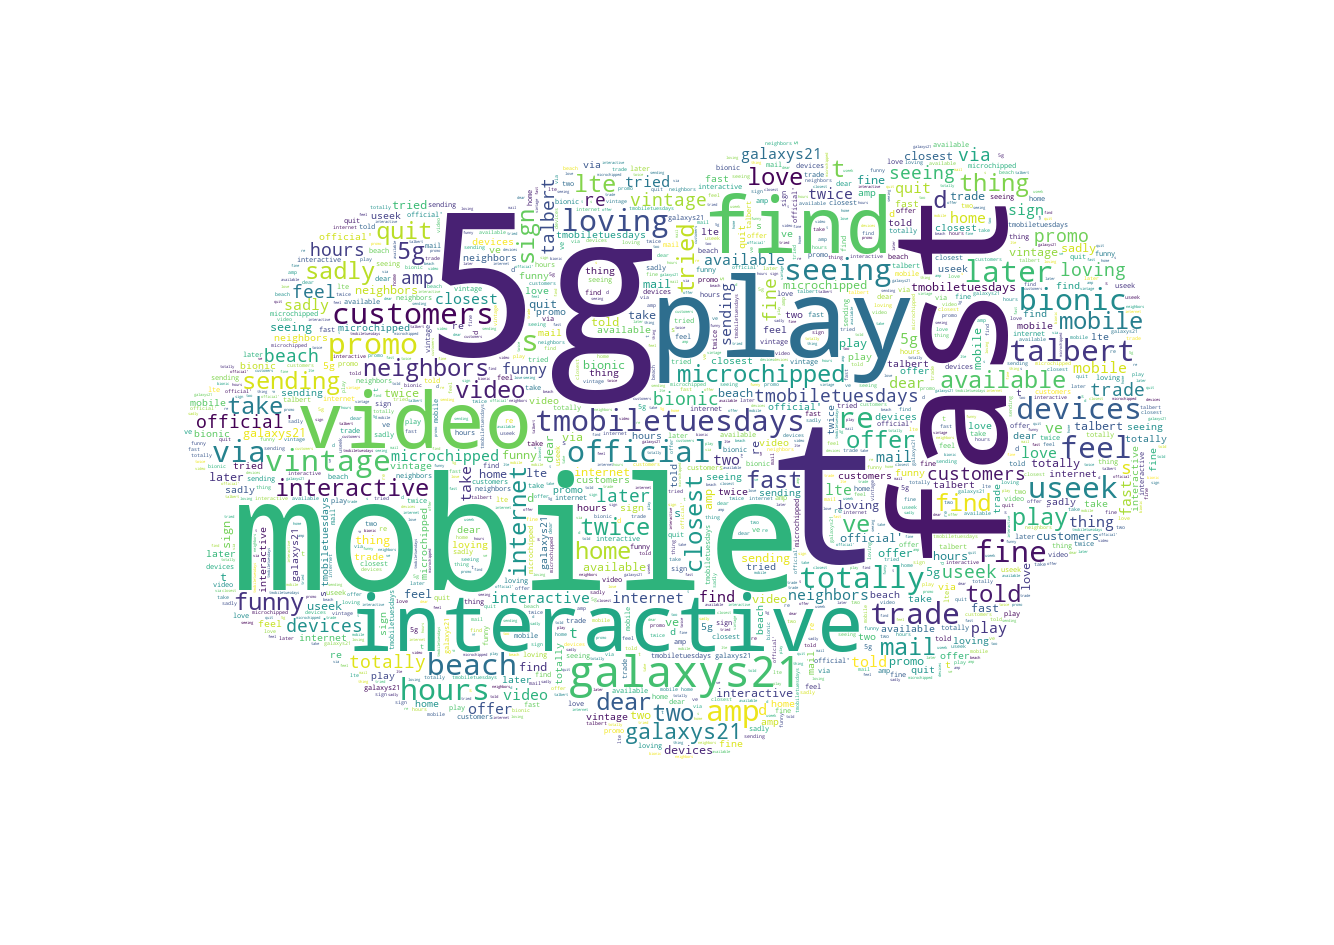

In [105]:
#Creating wordcloud for positive sentiment
create_wordcloud(mytest_positive['text'].values)

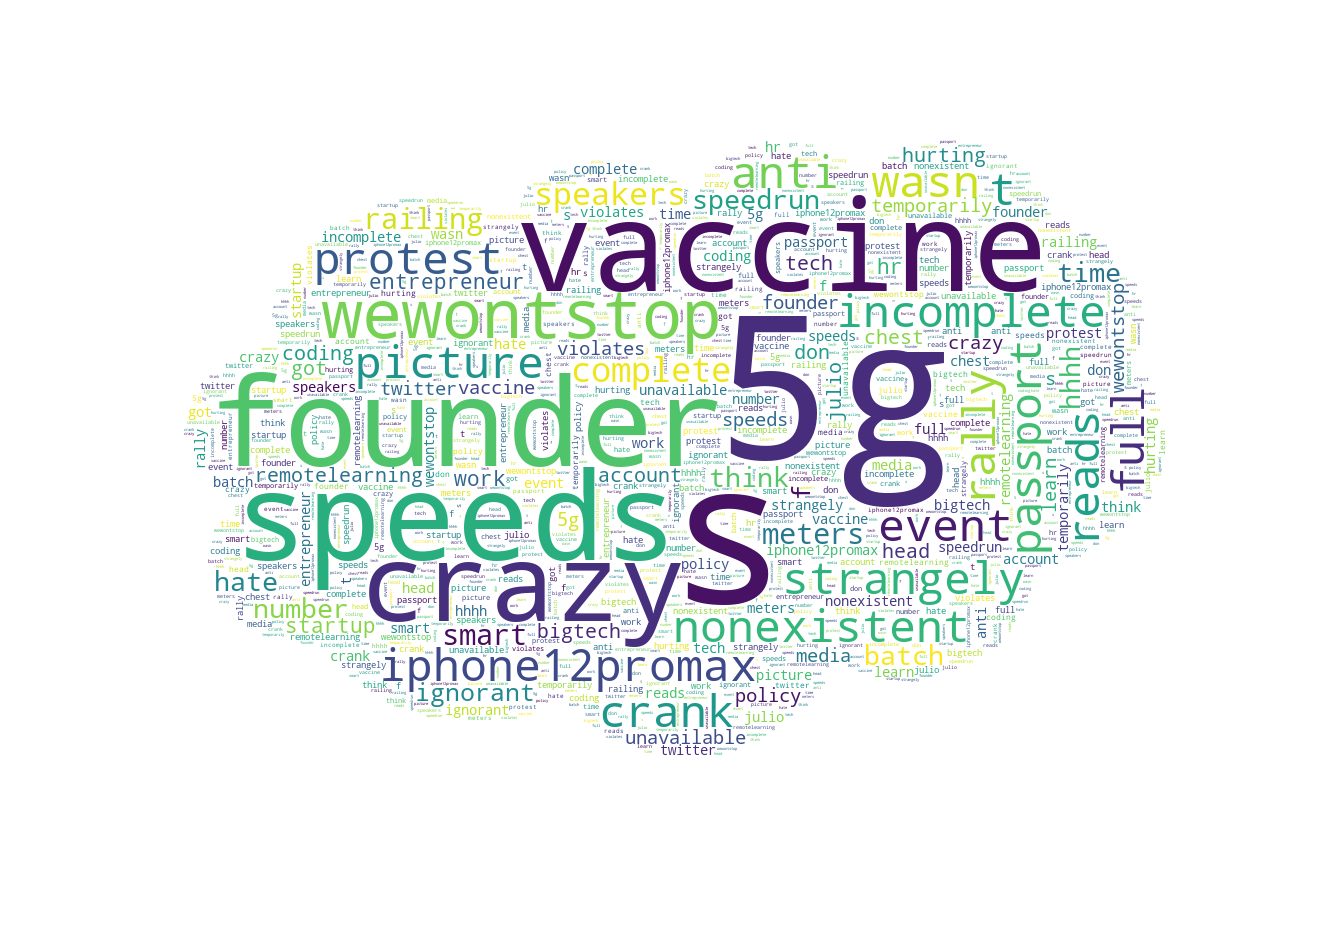

In [106]:
#Creating wordcloud for negative sentiment
create_wordcloud(mytest_negative['text'].values)

In [ ]:
#  https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d

In [237]:
#Calculating tweet’s lenght and word count
mytest['text_len'] = mytest['text'].astype(str).apply(len)
mytest['text_word_count'] = mytest['text'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(mytest.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,141.20
neutral,91.01
positive,159.82


In [238]:
round(pd.DataFrame(mytest.groupby('sentiment').text_word_count.mean()),2)

,text_word_count
sentiment,
negative,24.97
neutral,14.69
positive,26.50


In [239]:
#Removing Punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

mytest['punct'] = mytest['text'].apply(lambda x: remove_punct(x))

In [240]:
#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text

mytest['tokenized'] = mytest['punct'].apply(lambda x: tokenization(x.lower()))

In [241]:
#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
mytest['nonstop'] = mytest['tokenized'].apply(lambda x: remove_stopwords(x))

In [242]:
#Appliyng Stemmer
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

mytest['stemmed'] = mytest['nonstop'].apply(lambda x: stemming(x))

In [243]:
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
mytest.head()

,text,hashtag,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count,punct,tokenized,nonstop,stemmed
0,customers are loving this 5g for all trade in ...,[],0.600000,0.950000,positive,0.000,0.837,0.163,0.5994,128,21,customers are loving this g for all trade in p...,"[customers, are, loving, this, g, for, all, tr...","[customers, loving, g, trade, promo, seeing, v...","[custom, love, g, trade, promo, see, vintag, d..."
1,these 5g speeds are crazy wewontstop ipho...,"[WeWontStop, iPhone12ProMax]",-0.600000,0.900000,negative,0.286,0.714,0.000,-0.3400,58,7,these g speeds are crazy wewontstop iphon...,"[these, g, speeds, are, crazy, wewontstop, iph...","[g, speeds, crazy, wewontstop, iphonepromax, ]","[g, speed, crazi, wewontstop, iphonepromax, ]"
2,this reads very strangely because it s an inco...,[],0.149821,0.446964,negative,0.149,0.791,0.059,-0.4754,256,46,this reads very strangely because it s an inco...,"[this, reads, very, strangely, because, it, s,...","[reads, strangely, incomplete, picture, event,...","[read, strang, incomplet, pictur, event, prote..."
3,5g any speedrun but this time no batch number...,[],0.000000,0.000000,negative,0.229,0.653,0.118,-0.3291,53,10,g any speedrun but this time no batch number ...,"[g, any, speedrun, but, this, time, no, batch,...","[g, speedrun, time, batch, number, hhhh, ]","[g, speedrun, time, batch, number, hhhh, ]"
4,i can hear colors with the 5g update,[],0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000,38,8,i can hear colors with the g update,"[i, can, hear, colors, with, the, g, update, ]","[hear, colors, g, update, ]","[hear, color, g, updat, ]"


In [244]:
#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(mytest['text'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))
#print(countVectorizer.get_feature_names())

7269 Number of reviews has 11234 words


In [245]:
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

,,aa,aaa,aaaa,aaaaaaaaaah,aaaaaaaand,aac,aacr,aag,aagaya,...,zone,zoom,zoooooom,zorb,zte,zucchini,zuck,zuckerberg,zune,zx
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [246]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

,0
,6580
amp,1492
get,1135
oscar,922
mobil,823
win,817
via,783
galaxi,672
could,632
gift,577


In [193]:
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [195]:
#n2_bigram
n2_bigrams = get_top_n_gram(mytest['text'],(2,2),20)
n2_bigrams

[('amp win', 567),
 ('5g portal', 565),
 ('5g oscars', 562),
 ('oscars gift', 562),
 ('gift bag', 562),
 ('mobile 5g', 467),
 ('5g fast', 458),
 ('galaxys21 5g', 447),
 ('5g tmobiletuesdays', 444),
 ('video galaxys21', 443),
 ('tmobiletuesdays useek', 443),
 ('useek official', 443),
 ('fast play', 442),
 ('play interactive', 442),
 ('interactive video', 442),
 ('awesome 5g', 303),
 ('win awesome', 301),
 ('sunday verizon5gaccess', 290),
 ('bag tune', 281),
 ('verizon5gaccess live', 261)]

In [196]:
#n3_trigram
n3_trigrams = get_top_n_gram(mytest['text'],(3,3),20)

n3_trigrams

[('5g oscars gift', 562),
 ('oscars gift bag', 562),
 ('galaxys21 5g tmobiletuesdays', 443),
 ('5g tmobiletuesdays useek', 443),
 ('tmobiletuesdays useek official', 443),
 ('5g fast play', 442),
 ('fast play interactive', 442),
 ('play interactive video', 442),
 ('interactive video galaxys21', 442),
 ('video galaxys21 5g', 442),
 ('mobile 5g fast', 441),
 ('amp win awesome', 301),
 ('win awesome 5g', 301),
 ('awesome 5g oscars', 301),
 ('gift bag tune', 281),
 ('5g portal sweepstakes', 257),
 ('5g portal sunday', 246),
 ('portal sunday verizon5gaccess', 246),
 ('sunday verizon5gaccess live', 243),
 ('engraving station 5g', 238)]

In [ ]:
# ------------------- Model ----------------- #

In [ ]:
#=======test==========#

In [247]:
test2= mytest[['text','tokenized']]
test2

,text,tokenized
0,customers are loving this 5g for all trade in ...,"[customers, are, loving, this, g, for, all, tr..."
1,these 5g speeds are crazy wewontstop ipho...,"[these, g, speeds, are, crazy, wewontstop, iph..."
2,this reads very strangely because it s an inco...,"[this, reads, very, strangely, because, it, s,..."
3,5g any speedrun but this time no batch number...,"[g, any, speedrun, but, this, time, no, batch,..."
4,i can hear colors with the 5g update,"[i, can, hear, colors, with, the, g, update, ]"
...,...,...
7264,are you t mobile 5g fast play this interacti...,"[are, you, t, mobile, g, fast, play, this, int..."
7265,are you t mobile 5g fast play this interacti...,"[are, you, t, mobile, g, fast, play, this, int..."
7266,are you t mobile 5g fast play this interacti...,"[are, you, t, mobile, g, fast, play, this, int..."
7267,are you t mobile 5g fast play this interacti...,"[are, you, t, mobile, g, fast, play, this, int..."


In [ ]:
# Applying Topic Modelling

In [308]:
from sklearn.feature_extraction.text import CountVectorizer

In [338]:
# max_df=0.9 => discard any words that appear in >90% of tweets
# min_df=25  => words that appear in less than 25 tweets will be discarded.

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation - tf:'term frequency'
tf = vectorizer.fit_transform(test2['text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [321]:
tf.shape

(7269, 724)

In [310]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [311]:
model.fit(tf)

LatentDirichletAllocation(random_state=0)

In [339]:
lda_features = model.transform(tf)
lda_features.shape

(7269, 10)

In [340]:
components_df = pd.DataFrame(model.components_, columns=vectorizer.get_feature_names())
components_df

,0,000,1,10,100,100daysofcode,108mp,11,12,120hz,...,y,year,years,yes,yesterday,yet,you,your,yours,z
0,61.099961,38.099914,155.483773,71.969364,16.989366,0.100005,28.099990,34.924046,32.237520,32.099991,...,5.157698,2.327882,0.100026,0.100011,1.704125,0.100011,0.100011,11.851646,0.100004,25.259551
1,0.100008,0.100010,0.100018,0.100012,0.100021,0.100002,0.100001,0.100001,0.100007,0.100000,...,0.820702,3.421468,0.100005,0.100014,0.100007,0.100021,460.785557,187.458784,3.578374,0.100012
2,0.100004,0.100042,0.100014,22.270479,0.100013,0.100007,0.100003,0.289330,83.707495,0.100002,...,0.100000,28.813638,18.946397,0.100003,0.100169,0.100005,3.250742,1.619895,0.100012,2.312740
3,0.100002,0.100002,0.100005,0.100002,0.100003,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100009,47.466528,0.100000,0.100003,0.100000,0.100004,191.146899,200.373532,0.100005,0.100001
4,0.100011,0.100007,20.233707,2.847241,0.100016,0.100003,0.100003,9.086597,7.683357,0.100003,...,34.008804,46.620178,43.057668,33.486242,25.197268,39.723094,93.319744,50.434877,0.100005,2.727679
5,0.100000,0.100002,16.673036,0.100000,0.100002,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,95.836424,0.100000,0.100001,0.100000,0.100000,756.399751,0.100006,68.621586,0.100001
6,0.100003,0.100005,0.100018,0.100020,0.100007,0.100004,0.100002,0.100003,0.100018,0.100001,...,3.403479,0.100007,0.100005,0.100011,0.100016,0.100023,148.845624,0.100064,0.100010,0.100007
7,0.100008,0.100009,26.338363,3.312804,5.618074,61.099973,0.100001,0.100018,0.100013,0.100002,...,0.109295,0.100006,1.295880,0.100009,9.396843,10.543588,0.100016,3.557227,0.100000,0.100000
8,0.100003,0.100010,24.771066,0.100076,9.692497,0.100006,0.100000,0.100003,4.771588,0.100002,...,0.100013,9.213867,0.100018,1.713705,0.101569,19.033253,123.148856,146.403969,0.100004,0.100007
9,0.100000,0.100000,0.100001,0.100001,0.100001,0.100000,0.100000,0.100000,0.100002,0.100000,...,0.100001,0.100003,0.100001,0.100001,0.100002,0.100001,478.902801,0.100001,0.100000,0.100003


In [312]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [313]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)
# seems need transformation? turn text into a sparse matrix?

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,for,207.6,you,460.8,the,405.3,the,421.8,the,1736.2,you,756.4,to,621.3,my,324.0,the,1105.9,via,599.0
1,with,191.3,and,272.5,in,334.7,red,209.1,i,1280.5,to,710.0,my,579.6,got,267.3,to,914.4,mobile,592.9
2,realme,171.7,to,245.0,to,256.3,your,200.4,a,966.7,amp,674.9,i,543.2,ai,222.9,and,675.6,t,573.9
3,pro,165.0,the,219.8,iphone,199.1,carpet,193.1,is,938.1,oscars,624.4,get,295.2,iot,212.7,a,553.9,video,536.3
4,2,156.5,network,207.8,new,196.8,you,191.1,and,864.3,the,511.2,in,212.9,i,202.8,in,495.7,fast,527.6
5,samsung,156.0,for,191.2,india,191.5,get,187.6,it,743.5,win,485.3,the,194.4,of,193.9,of,430.9,out,513.7
6,1,155.5,with,189.6,will,176.5,win,183.3,to,689.2,d,457.6,first,169.5,the,170.4,on,407.2,this,493.8
7,3,151.1,your,187.5,and,167.8,an,182.7,of,675.4,in,453.5,you,148.8,shot,167.3,we,394.0,find,492.1
8,in,136.4,t,148.4,on,161.7,could,178.4,my,586.4,could,438.9,got,136.8,second,149.1,amp,383.1,are,482.7
9,and,131.3,in,144.9,of,160.2,amp,177.9,s,540.2,bag,416.3,m,135.2,vaccine,138.1,is,364.2,you,478.9


In [ ]:
# test

In [349]:
# Materialize the sparse data
data_vectorized = vectorizer.fit_transform(test2['text'])
data_dense = data_vectorized.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.9374829461977716 %


In [351]:
lda_output = model.fit_transform(data_vectorized)

In [ ]:
# Diagnose model performance with perplexity and log-likelihood

In [354]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", model.score(data_vectorized))

Log Likelihood:  -603021.9207335251


In [355]:
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", model.perplexity(data_vectorized))
# On a different note, perplexity might not be the best measure to evaluate 
# topic models because it doesn’t consider the context and semantic 
# associations between words. 

Perplexity:  198.1116761758732


In [358]:
# See model parameters
from pprint import pprint
pprint(model.get_params())

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [360]:
# How to GridSearch the best LDA model?
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [368]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 25, 30]},
             return_train_score='warn')

In [369]:
# Best Model
best_lda_model = model.best_estimator_

In [370]:
# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}


In [371]:
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

Best Log Likelihood Score:  -151905.9189924958


In [372]:
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Model Perplexity:  199.4894403481053


In [373]:
# Compare LDA Model Performance Scores

In [380]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5,10,15,20,25]
#log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
#log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
#log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

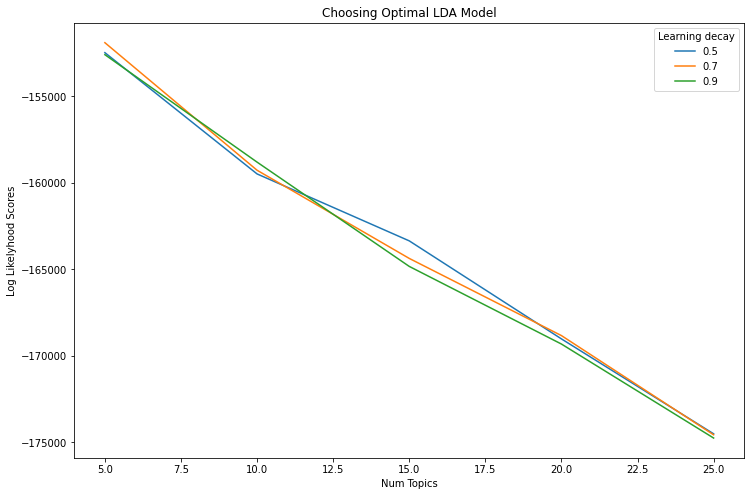

In [381]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [385]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [386]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.420952   8.115230       1        1  18.546207
5       0.648955  71.707100       2        1  14.789996
1      71.019684   9.971006       3        1  11.887749
8       3.785981  33.185135       4        1  11.011387
3     -42.666500  -9.222070       5        1  10.962667
2      -3.621689 -43.526516       6        1   8.955736
6      -3.632402  -4.171708       7        1   7.554052
9     -36.584400  35.804413       8        1   5.647460
4      44.391380  50.615383       9        1   5.499541
0      40.235809 -31.591665      10        1   5.145205, topic_info=    Term         Freq        Total Category  logprob  loglift
515    s  1318.000000  1318.000000  Default  30.0000  30.0000
296    i  2219.000000  2219.000000  Default  29.0000  29.0000
404   my  1749.000000  1749.000000  Default  28.0000  28.0000
318   it  1170.000000  1170.000000  Default  27.0000  27.0000
601  the  4797.000000  4797.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
300   in    98.658985  2527.683341  Topic10  -4.0853  -0.2763
479  pro    60.536842   229.876278  Topic10  -4.5738   1.6328
66   amp    75.608918  1493.154854  Topic10  -4.3514  -0.0160
237  for    62.075555  1732.055175  Topic10  -4.5487  -0.3616
425   of    60.748104  1568.856546  Topic10  -4.5703  -0.2843

[577 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         8  0.963406      0
0        10  0.031587      0
2         1  0.069085      1
2         2  0.097532      1
2         3  0.004064      1
...     ...       ...    ...
721       4  0.188440   your
721       6  0.003335   your
721       9  0.025014   your
721      10  0.005003   your
722       1  0.987317  yours

[1255 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 2, 9, 4, 3, 7, 10, 5, 1])

In [314]:
# comments : literature indicates  LDA (which works very well for longer text documents), 
#            does not work well on shorter text documents like tweets

In [315]:
# non-negative matrix factorisation (NMF) model

In [316]:
from sklearn.decomposition import NMF

In [323]:
model2 = NMF(n_components=number_of_topics, random_state=0)

In [324]:
model2.fit(tf)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=10, random_state=0)

In [325]:
# Transform the TF-IDF: nmf_features
nmf_features = model2.transform(tf)

In [326]:
nmf_features.shape

(7269, 10)

In [327]:
model2.components_.shape

(10, 724)

In [329]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(model2.components_, columns=vectorizer.get_feature_names())
components_df

,0,000,1,10,100,100daysofcode,108mp,11,12,120hz,...,y,year,years,yes,yesterday,yet,you,your,yours,z
0,0.043229,0.000000,0.000000,0.014472,0.000000,0.013055,0.000000,0.000000,0.047631,0.010860,...,0.012366,0.086692,0.016645,0.028557,0.015235,0.000000,0.000000,0.325120,0.000000,0.040103
1,0.000000,0.000000,0.015538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.283628,0.000000,0.000000,0.000000,0.000000,3.755390,0.502921,0.191470,0.000000
2,0.000000,0.000419,0.000000,0.000000,0.001204,0.002808,0.000740,0.000000,0.001343,0.001154,...,0.005643,0.000000,0.000000,0.000000,0.000000,0.005557,2.383518,0.053761,0.000000,0.000000
3,0.000000,0.000000,0.048831,0.009066,0.000000,0.000000,0.024260,0.006917,0.061941,0.008454,...,0.049144,0.000000,0.015785,0.020956,0.047706,0.085917,0.000000,0.000000,0.000000,0.000000
4,0.001159,0.023469,0.000000,0.000000,0.001523,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.018781,0.003170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.035743,0.032704,0.141078,0.057644,0.029240,0.001422,0.017768,0.020780,0.058192,0.014702,...,0.000000,0.000000,0.037758,0.042236,0.002178,0.000000,1.161860,0.572064,0.000000,0.000000
6,0.000000,0.000000,0.021660,0.002184,0.000000,0.000000,0.012075,0.000000,0.000000,0.000000,...,0.007376,0.730221,0.002760,0.012923,0.013578,0.019754,0.000000,0.060824,0.000000,0.010523
7,0.015487,0.017183,0.252337,0.029731,0.035324,0.038283,0.000000,0.052477,0.044717,0.000000,...,0.000000,0.000000,0.058890,0.000000,0.008134,0.062572,0.365972,0.078711,0.087214,0.014935
8,0.000000,0.015959,0.099572,0.122145,0.012545,0.047368,0.000000,0.034597,0.063555,0.002666,...,0.000000,0.000000,0.046346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.005958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046552,0.011705,...,0.011271,0.000000,0.042721,0.000000,0.010269,0.039061,0.000000,0.178738,0.029450,0.000000


In [330]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')
# topic 2 seems that AMP lauched campaigns with gifts

For topic 1 the words with the highest value are:
the       12.270999
of         2.053407
all        0.686434
on         0.532244
with       0.490577
we         0.438504
red        0.408256
carpet     0.390911
at         0.351631
that       0.342579
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
you                3.755390
amp                3.026201
oscars             2.809729
win                2.121967
verizon5gaccess    2.018271
gift               2.016116
portal             2.014986
bag                2.014797
sweepstakes        2.012880
could              2.007851
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
t         2.557845
you       2.383518
this      2.327400
mobile    2.322415
are       2.237270
out       2.206962
via       2.192097
fast      2.120811
video     2.109011
find      2.097571
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
i       6.194403
my      3.203514
m       1.122255
g

In [332]:
# Get the topic of a tweet/document/text
# Todo: split train and text for the given dataset & rerun from beginning
# below is a test

In [335]:
# get the topic of 162th line
my_document = test2.text[162]
my_document

'ever since sprint and   merged my data service has been terrible  went to the sprint store and they gave me an updated sim card for  real 5g  and my service is even worse '

In [336]:
pd.DataFrame(nmf_features).loc[162]
#  maximum value: the 6th(index 5) - 0.325096

0    0.066993
1    0.007788
2    0.000000
3    0.110985
4    0.118072
5    0.325096
6    0.011529
7    0.000000
8    0.000000
9    0.124679
Name: 162, dtype: float64

In [341]:
pd.DataFrame(nmf_features).loc[162].idxmax()

5

In [343]:
# number of documents for each topic
# pd.DataFrame(nmf_features).idxmax()

In [344]:
# Predict the Topic of a New Document

In [345]:
# eg., unseen doc: "New Insectoid mode on PUBG Mobile Lets go pew pew !!! 
#PUBGMOBILE #PUBGMVIP"
my_news = """New Insectoid mode on PUBG Mobile Lets go pew pew"""
 
# Transform the TF-IDF
X = vectorizer.transform([my_news])
# Transform the TF-IDF: nmf_features
nmf_features = model2.transform(X)

pd.DataFrame(nmf_features)

,0,1,2,3,4,5,6,7,8,9
0,0.003878,0.0,0.027797,0.005063,0.0,0.016792,0.0,0.00958,0.002002,0.015264


In [346]:
pd.DataFrame(nmf_features).idxmax(axis=1)
# the 3rd topic

0    2
dtype: int64